In [194]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from   sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0)
plt.style.use('seaborn-poster')

In [195]:
king = pd.read_excel("..\data\king_county_home_sales.xlsx", index_col= "Unnamed: 0" )
king.sample(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,sqft_above,...,zipcode,lat,long,sqft_living15,sqft_lot15,renovated,view_ord,condition_ord,grade_ord,age
19058,9551201560,2014-07-22,760000,2,1.00,1410,3600,1.5,0,1310,...,98103,47.6695,-122.338,1740,4200,0,0,3,4,90
18665,9169600209,2014-08-20,746300,3,1.75,2060,5721,1.0,0,1140,...,98136,47.5268,-122.388,2060,8124,0,2,2,6,51
14139,510000641,2015-01-30,662500,3,2.00,2070,4200,1.5,0,1670,...,98103,47.6624,-122.333,1490,4560,0,0,3,4,109
3096,2599001240,2014-05-27,200000,4,2.50,1720,9600,1.0,0,1120,...,98092,47.2917,-122.188,1520,9400,0,0,2,4,54
10672,5249803645,2014-08-29,452000,2,1.00,1220,6000,1.0,0,880,...,98118,47.5647,-122.270,1220,6840,0,0,2,3,77
12942,2019200220,2014-09-23,160000,3,2.25,1470,8682,1.0,0,1160,...,98003,47.2729,-122.299,1670,8359,0,0,2,4,30
5958,7010700660,2015-04-28,807000,3,2.50,1940,4000,2.0,0,1940,...,98199,47.6590,-122.398,1410,4000,0,0,3,6,15
4428,3815500165,2014-09-11,396000,5,2.75,2840,12253,1.0,0,1420,...,98028,47.7618,-122.253,2210,11620,0,0,2,4,55
10922,3705900292,2015-04-28,420000,3,2.00,1750,9239,1.0,0,1410,...,98133,47.7583,-122.339,1720,7874,0,0,2,5,26
2651,5459500125,2014-08-05,1000000,6,2.75,3600,9675,1.0,0,1940,...,98040,47.5726,-122.213,2990,9675,0,2,3,6,38


Here is a first attempt at a simple linear regression model using the sqft_living room of a home to model

In [196]:
# price as a function of sqfr_living room, this is just a pedigocial tool and will serve as a basis


X, y = king[['sqft_living']] , king[['price']]

# Generate train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.3, random_state=42
)

# Init, fit, score
model = LinearRegression()
model.fit(X_train, y_train)

print(f"Training score: {model.score(X_train, y_train)}")

print(f"Test score: {model.score(X_test, y_test)}")

Training score: 0.49217109776184653
Test score: 0.4938282899234566


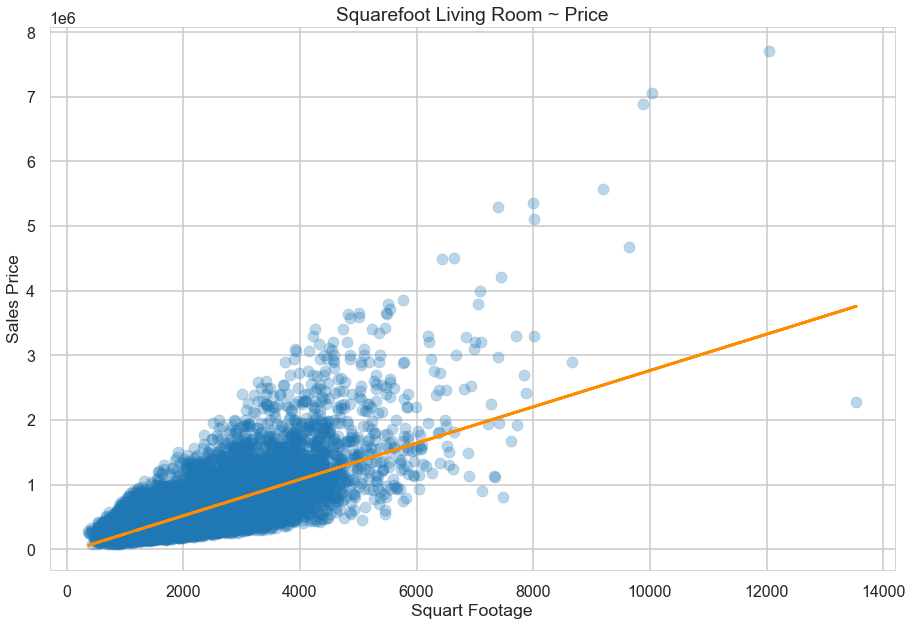

In [197]:
# plot fit
plt.scatter(king.sqft_living, king.price, alpha=0.3)
plt.plot(king.sqft_living, price_model.predict(king[['sqft_living']]), c='darkorange')
plt.title("Squarefoot Living Room ~ Price")
plt.xlabel("Squart Footage")
plt.ylabel("Sales Price")
plt.tight_layout()
plt.show()

Now it is time for a multi linear regression:

In [198]:
king.columns # calling all columns in order to determine what subset of columns we will use for our models
features = king[['bedrooms', 'bathrooms', 'sqft_living',
                 'sqft_lot', 'floors', 'waterfront', 'sqft_above',
                 'sqft_basement', 'lat', 'long', 'sqft_living15',
                 'sqft_lot15', 'view_ord', 'condition_ord', 'grade_ord', 'age', "renovated"]]

In [199]:
# mulit model time: (all ~ price) decided to use every column here except for yr_built since this column and age are redundant and zipcode since it is an arbitraruy number not relevant to our dataframe yet.

X, y = features, king[['price']]

# Generate train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.3, random_state=42
)


# Init, fit, score
multi_model = LinearRegression()
multi_model.fit(X_train, y_train)

print(f"Training score: {multi_model.score(X_train, y_train)}")
multi_model_score = multi_model.score(X_test, y_test)
print(f"Test score: {multi_model.score(X_test, y_test)}")


Training score: 0.7008430929351748
Test score: 0.6822292264304166


An r^2 score of 0..68 isn't bad but it isn't great either. Maybe we have some collinearity issues going on and we need to be more selective about our features. So its time to do some feature selection

In [200]:
def identify_correlated(df, threshold):
    """
    A function to identify highly correlated features.
    """
    # Compute correlation matrix with absolute values
    matrix = df.corr().abs()

    # Create a boolean mask
    mask = np.triu(np.ones_like(matrix, dtype=bool))

    # Subset the matrix
    reduced_matrix = matrix.mask(mask)

    # Find cols that meet the threshold
    to_drop = [c for c in reduced_matrix.columns if \
              any(reduced_matrix[c] > threshold)]

    return to_drop

# Thanks to this towards data science for this function: https://towardsdatascience.com/how-to-use-pairwise-correlation-for-robust-feature-selection-20a60ef7d10

In [201]:
to_drop = identify_correlated(king, .8) #proceeding with dropping these features that are highly correlated

king_reduced = king.drop(to_drop[1:], axis=1)

king_reduced.columns # here we can see that we have removed some features that are collinear

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'sqft_above', 'sqft_basement',
       'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'renovated',
       'view_ord', 'condition_ord', 'grade_ord', 'age'],
      dtype='object')

In [202]:
# Build feature/target arrays
X, y = king_reduced[['bedrooms', 'bathrooms', 'sqft_living',
                     'sqft_lot', 'floors', 'waterfront', 'sqft_above', 'sqft_basement',
                     'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'renovated',
                     'view_ord', 'condition_ord', 'grade_ord', 'age']] , king_reduced[['price']]

# Generate train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.3, random_state=42
)


# Init, fit, score
multi_model_red = LinearRegression()
multi_model_red.fit(X_train, y_train)

print(f"Training score: {multi_model_red.score(X_train, y_train)}")
multi_model_score_red = multi_model_red.score(X_test, y_test)
print(f"Test score: {multi_model_red.score(X_test, y_test)}")

print(f"\nOur r^2 score was {multi_model_score:.04f} and our new reduced score is {multi_model_score_red:.04f} this is a small increase with a decrease in features.")

Training score: 0.7049095466621058
Test score: 0.6873010029195377

Our r^2 score was 0.6822 and our new reduced score is 0.6873 this is a small increase with a decrease in features.


WOW! It seems that removing the features that were correlated with one another actually increased our score. This is great for two main reasons, 1) we are slightly more confident in our model 2) we are able to use less features which means that our model is more computationally efficent.